In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score
import MySQLdb
%matplotlib inline
warnings.filterwarnings("ignore")

# information used to create a database connection
sqluser = 'postgres'
dbname = 'mimic'
schema_name = 'public'
password = "jinaf3279"


con = MySQLdb.connect("localhost","wuyuef","jinaf3279","I501Fa20grp2_db" )
cur = con.cursor()



In [71]:
###############################################################################################################
######################                return subject_id who get CKD                        ####################
###############################################################################################################
def getSubID():
    query = """
    select subject_id from DIAGNOSES_ICD where icd9_code in ('5851','5852','5853','5854','5855','5859','585')
    """
    df = pd.read_sql_query(query,con)
    cur.execute("select subject_id from DIAGNOSES_ICD where icd9_code in ('5851','5852','5853','5854','5855','5859','585')")
    rows = cur.fetchall()
    subID=[]
    for r in rows:
        subID.append(r[0])
    return subID

#get CKD patients info
t = tuple(getSubID())


In [72]:
#df1 from patients

query = """
select subject_id, gender, dod from PATIENTS where subject_id in {}
""".format(t)
df1 = pd.read_sql_query(query,con)
df1.fillna(0, inplace=True)
df1

,subject_id,gender,dod
0,2036,M,0
1,2802,M,0
2,4282,F,0
3,5525,M,2116-06-26 00:00:00
4,14669,F,2109-03-05 00:00:00
...,...,...,...
4001,55639,F,2153-08-26 00:00:00
4002,64334,M,0
4003,45783,M,2136-06-21 00:00:00
4004,99491,M,2139-02-17 00:00:00


In [73]:
query = """
        select distinct subject_id, ethnicity, deathtime from ADMISSIONS where subject_id in {}
        """.format(t)
df2 = pd.read_sql_query(query,con)
for j in range(len(df2)):
    if df2['ethnicity'][j][0:5] == 'ASIAN':
        df2['ethnicity'][j] = 'ASIAN'
    elif df2['ethnicity'][j][0:5] == 'WHITE':
        df2['ethnicity'][j] = 'WHITE'
    elif df2['ethnicity'][j][0:8] == 'HISPANIC':
        df2['ethnicity'][j] = 'HISPANIC'
    elif df2['ethnicity'][j][0:13] == 'BLACK/AFRICAN':
        df2['ethnicity'][j] = 'BLACK'
    elif df2['ethnicity'][j][0:15] == 'AMERICAN INDIAN' or df2['ethnicity'][j][0:6] == 'INDIAN' :
        df2['ethnicity'][j] = 'ASIAN'
    elif df2['ethnicity'][j][0:7] == 'UNKNOWN' or df2['ethnicity'][j][0:6] == 'UNABLE' or df2['ethnicity'][j][0:7] == 'PATIENT':
        df2['ethnicity'][j] = None
    else:
        df2['ethnicity'][j] = 'OTHER'
for j in range(len(df2)):
    if pd.isnull(df2['deathtime'])[j]:
        df2['deathtime'][j] = 0
        
#drop the none value in ethnicity
df2 = df2.dropna()
df2

,subject_id,ethnicity,deathtime
0,2036,WHITE,0
1,2802,WHITE,0
2,4282,BLACK,0
3,5525,WHITE,0
4,5525,WHITE,2116-06-26 13:40:00
...,...,...,...
4460,55639,WHITE,2153-08-26 15:55:00
4461,64334,WHITE,0
4462,45783,WHITE,0
4464,29829,WHITE,2145-06-11 10:00:00


In [74]:
df = pd.merge(df1,df2, how='inner', on='subject_id')
df = df.drop_duplicates(subset = ["subject_id"])
df = df.reset_index()
df

,index,subject_id,gender,dod,ethnicity,deathtime
0,0,2036,M,0,WHITE,0
1,1,2802,M,0,WHITE,0
2,2,4282,F,0,BLACK,0
3,3,5525,M,2116-06-26 00:00:00,WHITE,0
4,5,14669,F,2109-03-05 00:00:00,WHITE,0
...,...,...,...,...,...,...
3800,4222,4843,F,0,WHITE,0
3801,4223,55639,F,2153-08-26 00:00:00,WHITE,2153-08-26 15:55:00
3802,4224,64334,M,0,WHITE,0
3803,4225,45783,M,2136-06-21 00:00:00,WHITE,0


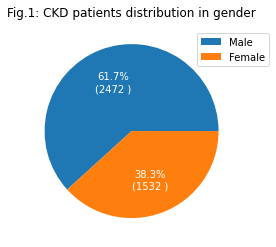

<class 'tuple'>


In [75]:
###############################################################################################################
######################                CKD distribution by GENDER                           ####################
###############################################################################################################
cur.execute("select subject_id, gender, dob, dod from PATIENTS where subject_id in {}".format(t))
rows = cur.fetchall()
gender = []
for r in rows:
    gender.append(r[1])

    
def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d} )".format(pct, absolute)

gender = [gender.count('M'),gender.count('F')]
label = ['Male', 'Female']
plt.pie(gender, labels=label, autopct=lambda pct: func(pct, gender),
       textprops=dict(color="w"))
plt.legend(label,loc=(.8,.8))
plt.title('Fig.1: CKD patients distribution in gender')
plt.show()
print(type(rows))

    


In [76]:

cur.execute("select subject_id, gender, dob, dod from PATIENTS where subject_id in {}".format(t))
rows = cur.fetchall()
gender = []
for r in rows:
    gender.append(r[1])

gender = [gender.count('M'),gender.count('F')]
label = ['Male', 'Female']

male_l, fm_l, male_d, fm_d  = 0, 0, 0, 0

for r in rows:
    
    if r[3]==None:
        if r[1]=="M":
            male_l +=1
        elif r[1]=="F":
            fm_l+=1
    else:
        if r[1]=="M":
            male_d +=1
        elif r[1]=="F":
            fm_d+=1
    

male_l, fm_l, male_d, fm_d

(1140, 672, 1333, 861)

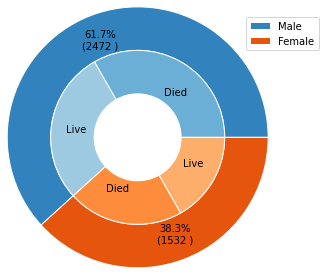

In [77]:
fig, ax = plt.subplots()

g = ['Died', 'Live', 'Died', 'Live']
vals = np.array([[male_d, male_l],[fm_d, fm_l]])

cmap = plt.get_cmap("tab20c")
outer_colors = cmap(np.array([0,1,2,3])*4)
inner_colors = cmap([1,2,5,6])

ax.pie(vals.sum(axis=1), radius=1.5, colors=outer_colors,autopct=lambda pct: func(pct, gender),pctdistance = 0.8,
       wedgeprops=dict(width=.5, edgecolor='w'))

ax.pie(vals.flatten(), radius=1, colors=inner_colors,
       wedgeprops=dict(width=.5, edgecolor='w'),labels=g, labeldistance=0.6)

plt.legend(label, loc = (1,.9))
plt.show()

Text(0.5, 1.0, 'Fig.3: CKD Mortality Rate by Gender')

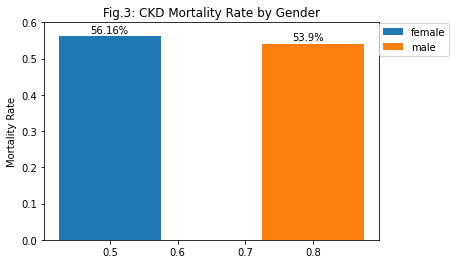

In [78]:
plt.bar(0.5, fm_d/gender[1] ,.15)
plt.bar(0.8, male_d/gender[0],.15)
plt.text(0.47,0.57,str(round(fm_d/gender[1]*100,2))+'%')
plt.text(0.77,0.55,str(round(male_d/gender[0]*100,2))+'%')
plt.ylim(0,0.6)
plt.ylabel('Mortality Rate')
plt.legend(['female','male'], loc=(1,0.845))
plt.title('Fig.3: CKD Mortality Rate by Gender')

In [79]:
###############################################################################################################
######################                CKD distribution by RACE                             ####################
###############################################################################################################
race = df['ethnicity'].unique()


ethnicity = []
for i in range(len(df['deathtime'])):
    if df['deathtime'][i]  != 0 or df['dod'][i]!=0:
        ethnicity.append(df['ethnicity'][i])
death = {}
for i in range(len(race)):
    death[race[i]]=ethnicity.count(race[i])

ori = [3001, 472, 99, 111, 122]

die = []
for i in death.values():
    die.append(i)
live = []
for i in range(len(ori)):
    live.append(ori[i]-die[i])
live





[1273, 256, 49, 66, 80]

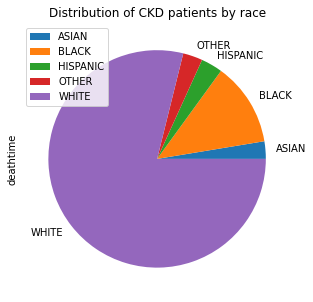

,index,gender,dod,deathtime
ethnicity,,,,
ASIAN,99,99,99,99
BLACK,472,472,472,472
HISPANIC,122,122,122,122
OTHER,111,111,111,111
WHITE,3001,3001,3001,3001


In [80]:
n = df.set_index(["ethnicity", 'subject_id']).count(level="ethnicity")
n.plot.pie(y='deathtime',figsize=(5, 5), title='Distribution of CKD patients by race')
plt.show()
n

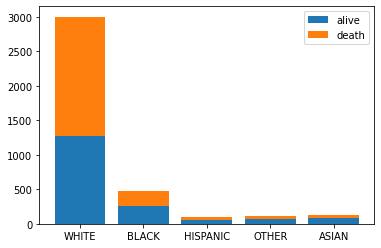

In [81]:
plt.bar(death.keys(), live)
plt.bar(death.keys(), death.values(), bottom=live)

plt.legend(['alive', 'death'])
plt.show()


Text(0.5, 1.0, 'Mortality rate by race')

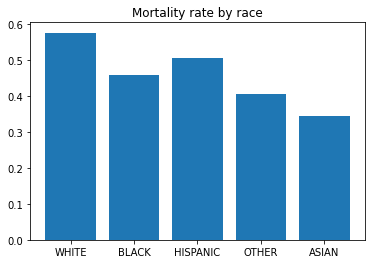

In [82]:
mo_race = []

value = list(death.values())
for i in range(len(ori)):
    mo_race.append(value[i]/ori[i])
plt.bar(death.keys(), mo_race)
plt.title('Mortality rate by race')

In [83]:
df

,index,subject_id,gender,dod,ethnicity,deathtime
0,0,2036,M,0,WHITE,0
1,1,2802,M,0,WHITE,0
2,2,4282,F,0,BLACK,0
3,3,5525,M,2116-06-26 00:00:00,WHITE,0
4,5,14669,F,2109-03-05 00:00:00,WHITE,0
...,...,...,...,...,...,...
3800,4222,4843,F,0,WHITE,0
3801,4223,55639,F,2153-08-26 00:00:00,WHITE,2153-08-26 15:55:00
3802,4224,64334,M,0,WHITE,0
3803,4225,45783,M,2136-06-21 00:00:00,WHITE,0


In [84]:
# df = df.drop(['dod','deathtime'],1)

'''
F is 0, M is 1 
'''

for i in range(len(df)):
    if df['gender'][i]== 'F':
        df['gender'][i] = 0
    elif df['gender'][i]== 'M':
        df['gender'][i] = 1


'''
Other is 0, Asian is 1, Black is 2, Hispanic is 3, White is 4
'''
for i in range(len(df)):
    if df['ethnicity'][i]=='OTHER':
        df['ethnicity'][i]=0
    elif df['ethnicity'][i]=='ASIAN':
        df['ethnicity'][i]=1
    elif df['ethnicity'][i]=='BLACK':
        df['ethnicity'][i]=2
    elif df['ethnicity'][i]=='HISPANIC':
        df['ethnicity'][i]=3
    elif df['ethnicity'][i]=='WHITE':
        df['ethnicity'][i]=4 

'''
died is 0, alive is 1
'''       
for i in range(len(df)):
    if df['deathtime'][i]!=0 or df['dod'][i]!=0:
        df['deathtime'][i] = 0
    else:
        df['deathtime'][i] = 1
df = df.drop(['dod'],1)

In [85]:
# pd.set_option('display.max_rows', df.shape[0]+1)
df

,index,subject_id,gender,ethnicity,deathtime
0,0,2036,1,4,1
1,1,2802,1,4,1
2,2,4282,0,2,1
3,3,5525,1,4,0
4,5,14669,0,4,0
...,...,...,...,...,...
3800,4222,4843,0,4,1
3801,4223,55639,0,4,0
3802,4224,64334,1,4,1
3803,4225,45783,1,4,0


In [86]:

X = df[['gender', 'ethnicity']]
y=df['deathtime'].astype('int')
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=0)
logistic_regression= LogisticRegression()
logistic_regression.fit(X_train,y_train)
y_pred=logistic_regression.predict(X_test)
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])


In [87]:

print('Accuracy: ',accuracy_score(y_test, y_pred))


Accuracy:  0.5779334500875657


In [88]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.58      0.86      0.69       632
           1       0.57      0.23      0.32       510

    accuracy                           0.58      1142
   macro avg       0.57      0.54      0.51      1142
weighted avg       0.57      0.58      0.53      1142



In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3805 entries, 0 to 3804
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   index       3805 non-null   int64 
 1   subject_id  3805 non-null   int64 
 2   gender      3805 non-null   object
 3   ethnicity   3805 non-null   object
 4   deathtime   3805 non-null   object
dtypes: int64(2), object(3)
memory usage: 148.8+ KB


In [150]:
query = """
select * from ckd_test_use_rly_fnl
"""

df = pd.read_sql_query(query,con)
# df = df[df['CKD_Comp']==1]

df
for j in range(len(df)):
    if df['ETHNICITY'][j][0:5] == 'ASIAN':
        df['ETHNICITY'][j] = 'ASIAN'
    elif df['ETHNICITY'][j][0:5] == 'WHITE':
        df['ETHNICITY'][j] = 'WHITE'
    elif df['ETHNICITY'][j][0:8] == 'HISPANIC':
        df['ETHNICITY'][j] = 'HISPANIC'
    elif df['ETHNICITY'][j][0:13] == 'BLACK/AFRICAN':
        df['ETHNICITY'][j] = 'BLACK'
    elif df['ETHNICITY'][j][0:15] == 'AMERICAN INDIAN' or df['ETHNICITY'][j][0:6] == 'INDIAN' :
        df['ETHNICITY'][j] = 'ASIAN'
    elif df['ETHNICITY'][j][0:7] == 'UNKNOWN' or df['ETHNICITY'][j][0:6] == 'UNABLE' or df['ETHNICITY'][j][0:7] == 'PATIENT':
        df['ETHNICITY'][j] = None
    else:
        df['ETHNICITY'][j] = 'OTHER'


In [151]:
df
# from scipy import stats
# stats.ttest_ind(df['CKD_Comp'],df['DOD_BIN'])

,SUBJECT_ID,CKD_Comp,Hyper_Comp,Diab_Comp,GENDER,DOB,DOD,ETHNICITY,DOD_BIN
0,2,0,0,0,M,87127,,ASIAN,0
1,3,0,0,0,M,45758,73945,WHITE,1
2,4,0,0,0,F,88887,,WHITE,0
3,5,0,0,0,M,74178,,ASIAN,0
4,6,0,1,0,F,76509,,WHITE,0
...,...,...,...,...,...,...,...,...,...
46806,99985,0,0,0,M,83009,,WHITE,0
46807,99991,0,1,1,M,86661,,WHITE,0
46808,99992,0,1,0,F,65305,,WHITE,0
46809,99995,0,0,1,F,57859,90488,WHITE,1


In [152]:
'''
F is 0, M is 1 
'''

for i in range(len(df)):
    if df['GENDER'][i]== 'F':
        df['GENDER'][i] = 0
    elif df['GENDER'][i]== 'M':
        df['GENDER'][i] = 1


'''
Other is 0, Asian is 1, Black is 2, Hispanic is 3, White is 4
'''
for i in range(len(df)):
    if df['ETHNICITY'][i]=='OTHER':
        df['ETHNICITY'][i]=0
    elif df['ETHNICITY'][i]=='ASIAN':
        df['ETHNICITY'][i]=1
    elif df['ETHNICITY'][i]=='BLACK':
        df['ETHNICITY'][i]=2
    elif df['ETHNICITY'][i]=='HISPANIC':
        df['ETHNICITY'][i]=3
    elif df['ETHNICITY'][i]=='WHITE':
        df['ETHNICITY'][i]=4 

In [153]:
df=df.dropna()

df

,SUBJECT_ID,CKD_Comp,Hyper_Comp,Diab_Comp,GENDER,DOB,DOD,ETHNICITY,DOD_BIN
0,2,0,0,0,1,87127,,1,0
1,3,0,0,0,1,45758,73945,4,1
2,4,0,0,0,0,88887,,4,0
3,5,0,0,0,1,74178,,1,0
4,6,0,1,0,0,76509,,4,0
...,...,...,...,...,...,...,...,...,...
46806,99985,0,0,0,1,83009,,4,0
46807,99991,0,1,1,1,86661,,4,0
46808,99992,0,1,0,0,65305,,4,0
46809,99995,0,0,1,0,57859,90488,4,1


In [154]:
df = df.drop(['SUBJECT_ID','DOB','DOD'],1)
df

,CKD_Comp,Hyper_Comp,Diab_Comp,GENDER,ETHNICITY,DOD_BIN
0,0,0,0,1,1,0
1,0,0,0,1,4,1
2,0,0,0,0,4,0
3,0,0,0,1,1,0
4,0,1,0,0,4,0
...,...,...,...,...,...,...
46806,0,0,0,1,4,0
46807,0,1,1,1,4,0
46808,0,1,0,0,4,0
46809,0,0,1,0,4,1


In [122]:
df1 = df[df['Hyper_Comp']==1]
df1

,SUBJECT_ID,CKD_Comp,Hyper_Comp,Diab_Comp,GENDER,ETHNICITY,DOD_BIN
51,59,1,1,1,0,4,1
97,107,1,1,0,1,3,0
99,109,1,1,0,0,2,1
102,112,1,1,0,1,4,1
113,124,1,1,0,1,4,1
...,...,...,...,...,...,...,...
46784,99901,1,1,1,1,4,0
46789,99923,1,1,0,1,4,0
46795,99938,1,1,1,1,4,0
46796,99939,1,1,0,1,3,0


In [124]:
df2 = df1[df1['Diab_Comp']==1]
df2

,SUBJECT_ID,CKD_Comp,Hyper_Comp,Diab_Comp,GENDER,ETHNICITY,DOD_BIN
51,59,1,1,1,0,4,1
177,188,1,1,1,1,4,1
180,191,1,1,1,1,1,0
181,191,1,1,1,1,1,0
196,209,1,1,1,1,4,0
...,...,...,...,...,...,...,...
46780,99893,1,1,1,1,4,1
46782,99897,1,1,1,1,0,0
46783,99899,1,1,1,1,2,1
46784,99901,1,1,1,1,4,0


In [134]:
X = df2[['GENDER', 'ETHNICITY', 'CKD_Comp']]
y=df2['DOD_BIN'].astype('int')
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=0)
logistic_regression= LogisticRegression()
logistic_regression.fit(X_train,y_train)
y_pred=logistic_regression.predict(X_test)
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
print('Accuracy: ',accuracy_score(y_test, y_pred))

Accuracy:  0.5329249617151608


In [131]:
df

,SUBJECT_ID,CKD_Comp,Hyper_Comp,Diab_Comp,GENDER,ETHNICITY,DOD_BIN
51,59,1,1,1,0,4,1
60,68,1,0,0,0,2,1
76,85,1,0,0,1,4,1
97,107,1,1,0,1,3,0
99,109,1,1,0,0,2,1
...,...,...,...,...,...,...,...
46789,99923,1,1,0,1,4,0
46793,99936,1,0,0,0,4,1
46795,99938,1,1,1,1,4,0
46796,99939,1,1,0,1,3,0
